In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from IPython.display import display, clear_output
import pandas as pd
import time
import json

from collections import OrderedDict
from collections import namedtuple
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=90)
%load_ext tensorboard
!pip install pytorch-lr-finder
import pytorch_lr_finder as lr_finder

In [3]:
torch.cuda.is_available()

True

In [ ]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [5]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.relu = nn.ReLU()
    self.pool = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5),
                           stride=(1,1), padding=(2,2))
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5),
                           stride=(1,1), padding=(0,0))
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5),
                           stride=(1,1), padding=(0,0))
    self.linear1 = nn.Linear(in_features=120, out_features=84)
    self.linear2 = nn.Linear(in_features=84, out_features=10)

  def forward(self, t):
    t = self.relu(self.conv1(t))
    t = self.pool(t)
    t = self.relu(self.conv2(t))
    t = self.pool(t)
    t = self.relu(self.conv3(t))
    t = t.reshape(t.shape[0], -1)
    t = self.relu(self.linear1(t))
    t = self.linear2(t)

    return t

In [6]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [7]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        
        Run = namedtuple('Run', params.keys())
        
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        
        return runs

In [8]:
class RunManager():
    def __init__(self):
        
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None
        self.loader = None
        self.tb = None
        
    def begin_run(self, run, network, loader):
        
        self.run_start_time = time.time()
        
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')
        
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('images', grid)
        self.tb.add_graph(
            self.network,
            images.to(getattr(run, 'device', 'cpu'))
            )
        
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0
        
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
    
    def end_epoch(self):
        
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
        
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
            
        results = OrderedDict()
        results['run'] = self.run_count
        results['epoch'] = self.epoch_count
        results['loss'] = loss
        results['accuracy'] = accuracy
        results['epoch_duration'] = epoch_duration
        results['run_duration'] = run_duration
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        
        clear_output(wait=True)
        display(df)
        
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * self.loader.batch_size
        
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
        
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName):
        
        pd.DataFrame.from_dict(
            self.run_data,
            orient='columns'
        ).to_csv(f'{fileName}.csv')
        
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

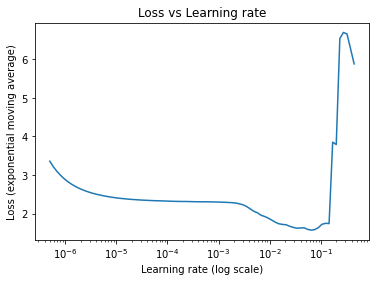

In [9]:
train_loader = DataLoader(
          train_set,
          batch_size=64,
          shuffle=True
    )

model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
lrf = lr_finder.LearningRateFinder(model, criterion, optimizer)
lrf.fit(train_loader)
lrf.plot()

In [ ]:
params = OrderedDict(
    lr=[5e-3,1e-2],
    batch_size=[64,1000],
    shuffle=[True],
    num_workers=[0,1],
    device=['cuda'] 
)

m = RunManager()
for run in RunBuilder.get_runs(params):
    
    device = torch.device(run.device)
    network = LeNet().to(device)
    loader = DataLoader(
        train_set,
        batch_size = run.batch_size,
        shuffle = run.shuffle,
        num_workers = run.num_workers
    )
    optimizer = optim.Adam(
        network.parameters(), lr=run.lr
    )
    
    m.begin_run(run, network, loader)
    for epoch in range(5):
        m.begin_epoch()
        for batch in loader:
            
            images = batch[0].to(device)
            labels = batch[1].to(device)
            preds = network(images)
            loss = F.cross_entropy(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            m.track_loss(loss)
            m.track_num_correct(preds, labels)
            
        m.end_epoch()
    m.end_run()
m.save('results')

In [ ]:
%tensorboard --logdir=runs